# Implementing FedAvg

In [11]:
###
# STEP 0: SETUP, PARAMETERS, AND MODEL
###

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [12]:

# --- 0.1: Global Parameters ---
# These parameters are set for all Task 2 experiments.
NUM_CLIENTS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 32 # Mini-batch size for local training
TOTAL_COMMUNICATION_ROUNDS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

print(f"--- Experimental Setup ---")
print(f"Device: {DEVICE}")
print(f"Clients: {NUM_CLIENTS}, Rounds: {TOTAL_COMMUNICATION_ROUNDS}")
print(f"LR: {LEARNING_RATE}, Batch Size: {BATCH_SIZE}")

# --- 0.2: Reproducibility ---
# Set a fixed seed for torch, numpy, and random.
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Set random seed to {SEED} for reproducibility.")

# --- 0.3: Model Architecture ---
# Using the same SimpleCNN from Task 1
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 is the flattened size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 0.4: Save Initial Model State ---
# This is critical for a fair comparison across all experiments.
# Every run will start from these *exact* same initial weights.
try:
    global_model = SimpleCNN().to(DEVICE)
    INITIAL_MODEL_STATE = copy.deepcopy(global_model.state_dict())
    print("SimpleCNN model defined and initial state saved successfully.")
except Exception as e:
    print(f"An error occurred during model initialization: {e}")

--- Experimental Setup ---
Device: cuda
Clients: 10, Rounds: 20
LR: 0.01, Batch Size: 32
Set random seed to 42 for reproducibility.
SimpleCNN model defined and initial state saved successfully.


In [13]:
###
# STEP 1: DATA LOADING AND IID PARTITIONING
###

# --- 1.1: Load Dataset & Define Transforms ---
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

try:
    print("Loading CIFAR-10 dataset...")
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_cifar
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_cifar
    )
    
    # --- 1.2: Create Global Test Loader ---
    # This loader is used by the server to evaluate the global model
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)
    
    print(f"CIFAR-10 loaded: {len(train_dataset)} train, {len(test_dataset)} test samples.")

except Exception as e:
    print(f"Error loading CIFAR-10. This might be a Kaggle network issue. Error: {e}")

# --- 1.3: Partitioning Function (IID) ---
def create_iid_partitions(dataset, num_clients):
    """
    Splits the dataset into num_clients IID partitions.
    """
    num_samples = len(dataset)
    indices = list(range(num_samples))
    samples_per_client = num_samples // num_clients
    
    # Shuffle indices for IID distribution
    np.random.shuffle(indices)
    
    list_of_datasets = []
    for i in range(num_clients):
        start_idx = i * samples_per_client
        # The last client gets all remaining samples
        if i == num_clients - 1:
            end_idx = num_samples
        else:
            end_idx = (i + 1) * samples_per_client
            
        client_indices = indices[start_idx:end_idx]
        client_dataset = Subset(dataset, client_indices)
        list_of_datasets.append(client_dataset)
        
    return list_of_datasets

# --- 1.4: Create Client Partitions and Loaders ---
try:
    client_datasets = create_iid_partitions(train_dataset, NUM_CLIENTS)
    
    print(f"\nCreated {len(client_datasets)} IID partitions.")
    for i, dataset in enumerate(client_datasets):
        print(f"  Client {i}: {len(dataset)} samples")
        
    # --- This is the key part for Task 2 ---
    # Create a list of DataLoaders, one for each client,
    # using the mini-batch BATCH_SIZE.
    client_train_loaders = [
        DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        for dataset in client_datasets
    ]
    
    print(f"\nCreated {len(client_train_loaders)} client mini-batch DataLoaders (Batch Size: {BATCH_SIZE}).")

except NameError:
    print("\n--- WARNING ---")
    print("train_dataset is not defined. Did Step 0 fail?")
except Exception as e:
    print(f"\nAn error occurred during partitioning: {e}")

Loading CIFAR-10 dataset...
CIFAR-10 loaded: 50000 train, 10000 test samples.

Created 10 IID partitions.
  Client 0: 5000 samples
  Client 1: 5000 samples
  Client 2: 5000 samples
  Client 3: 5000 samples
  Client 4: 5000 samples
  Client 5: 5000 samples
  Client 6: 5000 samples
  Client 7: 5000 samples
  Client 8: 5000 samples
  Client 9: 5000 samples

Created 10 client mini-batch DataLoaders (Batch Size: 32).


In [14]:
###
# STEP 2: CORE FEDAVG IMPLEMENTATION (CLASSES)
###

# --- 2.1: Define the Client Class ---
class Client:
    """
    Represents a client in the FedAvg setup.
    Each client has its own local data loader and performs
    local training using mini-batch SGD.
    """
    def __init__(self, client_id, local_train_loader, device):
        self.client_id = client_id
        self.local_train_loader = local_train_loader
        self.local_data_size = len(local_train_loader.dataset)
        self.device = device

    def local_train(self, global_model_state_dict, K_epochs, lr, criterion):
        """
        Performs K epochs of local mini-batch training.
        
        Args:
            global_model_state_dict (OrderedDict): The weights of the global model.
            K_epochs (int): The number of local epochs (K).
            lr (float): The learning rate.
            criterion (nn.Module): The loss function.
            
        Returns:
            (OrderedDict, int): A tuple containing the updated local model
                                state_dict and the size of this client's
                                local dataset.
        """
        # Create a new model instance and load the global model's weights
        local_model = SimpleCNN().to(self.device)
        local_model.load_state_dict(global_model_state_dict)
        
        # Set the model to training mode
        local_model.train()
        
        # Set up the optimizer for local training
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        
        # --- Local Training Loop ---
        for epoch in range(K_epochs):
            for data, labels in self.local_train_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = local_model(data)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
        # Return the updated state dictionary and the number of samples
        return local_model.state_dict(), self.local_data_size

# --- 2.2: Define the Server Class ---
class Server:
    """
    Represents the central server in the FedAvg setup.
    It manages aggregation and evaluation.
    """
    def __init__(self, global_model, test_loader, device, criterion):
        self.global_model = global_model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.criterion = criterion

    def aggregate_models(self, client_updates):
        """
        Performs federated averaging on the client model weights.
        
        Args:
            client_updates (list): A list of tuples, where each tuple is
                                   (client_state_dict, num_samples).
        """
        total_samples = sum([num_samples for _, num_samples in client_updates])
        
        # Create a new state_dict for the aggregated model, initialized to zeros
        aggregated_state_dict = self.global_model.state_dict()
        for key in aggregated_state_dict:
            aggregated_state_dict[key] = torch.zeros_like(aggregated_state_dict[key])

        # --- Perform Weighted Averaging ---
        for client_state_dict, num_samples in client_updates:
            weight = num_samples / total_samples
            for key in aggregated_state_dict:
                # Add the weighted parameters from this client
                aggregated_state_dict[key] += client_state_dict[key] * weight
        
        # Load the new averaged weights into the global model
        self.global_model.load_state_dict(aggregated_state_dict)

    def evaluate_global_model(self):
        """
        Evaluates the current global model on the hold-out test set.
        
        Returns:
            (float, float): A tuple containing the average test loss and test accuracy.
        """
        self.global_model.eval() # Set model to evaluation mode
        
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in self.test_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                outputs = self.global_model(data)
                loss = self.criterion(outputs, labels)
                
                test_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        avg_loss = test_loss / total
        accuracy = 100 * correct / total
        
        return avg_loss, accuracy

# --- 2.3: Initialization and Verification ---
try:
    # --- Define Loss Function ---
    global_criterion = nn.CrossEntropyLoss()
    
    # --- Instantiate Server ---
    # We create the server with our initial global model
    server_model_instance = SimpleCNN().to(DEVICE)
    server_model_instance.load_state_dict(copy.deepcopy(INITIAL_MODEL_STATE))
    
    server = Server(server_model_instance, test_loader, DEVICE, global_criterion)
    print("Server instantiated successfully.")

    # --- Instantiate Clients ---
    clients = [
        Client(client_id=i, local_train_loader=client_train_loaders[i], device=DEVICE)
        for i in range(NUM_CLIENTS)
    ]
    print(f"{len(clients)} clients instantiated successfully.")

    # --- Quick Sanity Check ---
    # Evaluate the *untrained* initial model to get a baseline.
    initial_loss, initial_accuracy = server.evaluate_global_model()
    print(f"Initial model baseline: Test Loss = {initial_loss:.4f}, Test Accuracy = {initial_accuracy:.2f}%")
    
    # This accuracy should be around 10% (random guessing)
    assert initial_accuracy < 15, "Initial accuracy is too high."
    
except NameError as e:
    print(f"\n--- WARNING ---")
    print(f"A required variable is not defined. Did a previous step fail? Error: {e}")
except Exception as e:
    print(f"\nAn error occurred during instantiation: {e}")

Server instantiated successfully.
10 clients instantiated successfully.
Initial model baseline: Test Loss = 2.3055, Test Accuracy = 10.15%


In [15]:
###
# STEP 3: HELPER FUNCTION FOR CLIENT DRIFT
###

def calculate_weight_divergence(global_state, local_state):
    """
    Calculates the L2 norm (weight divergence) between two model state_dicts.
    This measures how far the local model has "drifted" from the
    global model in a single round. 
    
    Args:
        global_state (OrderedDict): The state_dict of the global model.
        local_state (OrderedDict): The state_dict of the local model.
        
    Returns:
        (float): The L2 norm of the difference between the model weights.
    """
    total_drift = 0.0
    for key in global_state:
        # Calculate the squared L2 norm of the difference for each parameter tensor
        drift = torch.norm(global_state[key].to(DEVICE) - local_state[key].to(DEVICE))**2
        total_drift += drift
        
    # Return the square root of the sum of squared norms
    return torch.sqrt(total_drift).item()

print("Helper function `calculate_weight_divergence` defined.")

Helper function `calculate_weight_divergence` defined.


In [16]:
###
# STEP 4: MAIN FEDERATED EXPERIMENT FUNCTION 🚀
###

def run_fedavg_experiment(clients_list, initial_model_state, rounds, K_epochs, 
                          sampling_fraction, lr, device, criterion, test_loader):
    """
    Runs a complete federated learning experiment (FedAvg).
    
    This function orchestrates the entire process:
    1. Samples clients.
    2. Runs local training on clients.
    3. Measures client drift.
    4. Aggregates models on the server.
    5. Evaluates the global model.
    
    Args:
        clients_list (list): The list of all Client objects.
        initial_model_state (OrderedDict): Starting weights.
        rounds (int): Total communication rounds.
        K_epochs (int): Number of local epochs (K).
        sampling_fraction (float): Fraction of clients to sample (f).
        lr (float): Learning rate.
        device (torch.device): CPU or CUDA.
        criterion (nn.Module): Loss function.
        test_loader (DataLoader): For server-side evaluation.
        
    Returns:
        dict: A history dictionary containing 'test_loss', 'test_accuracy',
              and 'avg_client_drift' for each round.
    """
    
    print(f"\n--- Starting FedAvg Experiment ---")
    print(f"Config: K={K_epochs}, f={sampling_fraction}, Rounds={rounds}, LR={lr}")
    
    # --- 1. Setup Server ---
    # We create a new server and model for each experiment,
    # starting from the *exact* same initial state.
    server_model = SimpleCNN().to(device)
    server_model.load_state_dict(copy.deepcopy(initial_model_state))
    server = Server(server_model, test_loader, device, criterion)
    
    # --- 2. Initialize History Storage ---
    history = {
        "test_loss": [], 
        "test_accuracy": [], 
        "avg_client_drift": []
    }
    
    # Evaluate the initial model (Round 0)
    initial_loss, initial_acc = server.evaluate_global_model()
    history["test_loss"].append(initial_loss)
    history["test_accuracy"].append(initial_acc)
    history["avg_client_drift"].append(0.0) # No drift at round 0
    
    print(f"Round 0 (Initial): Test Loss = {initial_loss:.4f}, "
          f"Test Accuracy = {initial_acc:.2f}%")
    
    # --- 3. Start Training Rounds ---
    num_clients_to_sample = int(len(clients_list) * sampling_fraction)
    
    for r in range(rounds):
        
        # Get the global model state *before* this round
        global_state_dict = copy.deepcopy(server.global_model.state_dict())
        
        # --- Client Selection ---
        selected_clients_indices = np.random.choice(
            range(len(clients_list)), num_clients_to_sample, replace=False
        )
        selected_clients = [clients_list[i] for i in selected_clients_indices]
        
        client_updates = []
        round_drifts = []
        
        # --- Client Training & Drift Calculation ---
        for client in selected_clients:
            
            # Run local training
            local_state_dict, num_samples = client.local_train(
                global_state_dict, K_epochs, lr, criterion
            )
            client_updates.append((local_state_dict, num_samples))
            
            # --- Measure Client Drift (Required) ---
            # 
            drift = calculate_weight_divergence(global_state_dict, local_state_dict)
            round_drifts.append(drift)
            
        # --- Server Aggregation ---
        server.aggregate_models(client_updates)
        
        # --- Server Evaluation ---
        test_loss, test_acc = server.evaluate_global_model()
        
        # --- Record History ---
        avg_drift = np.mean(round_drifts) if round_drifts else 0.0
        history["test_loss"].append(test_loss)
        history["test_accuracy"].append(test_acc)
        history["avg_client_drift"].append(avg_drift)
        
        print(f"Round {r + 1}/{rounds}: Test Loss = {test_loss:.4f}, "
              f"Test Accuracy = {test_acc:.2f}%, Avg Drift = {avg_drift:.4f}")
        
    print("--- FedAvg Experiment Finished ---")
    return history

print("Main experiment function `run_fedavg_experiment` defined.")

Main experiment function `run_fedavg_experiment` defined.


In [17]:
###
# STEP 5: EXPERIMENT 1 - IMPACT OF LOCAL EPOCHS (K)
###

# We will now run the first experiment as defined in the manual.
# We will keep client participation at 100% (f=1.0) to
# isolate the effect of K.

# This dictionary will store the results (history) for each 'K' value.
k_experiment_histories = {}
k_values = [1, 5, 10, 20]

print(f"--- Starting Experiment 1: Varying K ---")
print(f"Will test K values: {k_values}")
print(f"Total Rounds per experiment: {TOTAL_COMMUNICATION_ROUNDS}")

try:
    for k in k_values:
        # Run the experiment for the current value of K
        history = run_fedavg_experiment(
            clients_list=clients,
            initial_model_state=INITIAL_MODEL_STATE,
            rounds=TOTAL_COMMUNICATION_ROUNDS,
            K_epochs=k,
            sampling_fraction=1.0,  # Full participation [cite: 144]
            lr=LEARNING_RATE,
            device=DEVICE,
            criterion=global_criterion,
            test_loader=test_loader
        )
        
        # Store the history using the K value as the key
        k_experiment_histories[k] = history
        print(f"--- Finished K={k} experiment. ---")

    print("\n--- All K experiments finished successfully. ---")
    print(f"Results stored in `k_experiment_histories` for keys: {list(k_experiment_histories.keys())}")

except NameError as e:
    print(f"\n--- WARNING ---")
    print(f"A required variable is not defined. Did a previous step fail? Error: {e}")
except Exception as e:
    print(f"\nAn error occurred during Experiment 1: {e}")

--- Starting Experiment 1: Varying K ---
Will test K values: [1, 5, 10, 20]
Total Rounds per experiment: 20

--- Starting FedAvg Experiment ---
Config: K=1, f=1.0, Rounds=20, LR=0.01
Round 0 (Initial): Test Loss = 2.3055, Test Accuracy = 10.15%
Round 1/20: Test Loss = 2.3029, Test Accuracy = 11.33%, Avg Drift = 0.0670
Round 2/20: Test Loss = 2.3001, Test Accuracy = 14.72%, Avg Drift = 0.0696
Round 3/20: Test Loss = 2.2958, Test Accuracy = 16.15%, Avg Drift = 0.0845
Round 4/20: Test Loss = 2.2869, Test Accuracy = 17.11%, Avg Drift = 0.1196
Round 5/20: Test Loss = 2.2628, Test Accuracy = 18.00%, Avg Drift = 0.1943
Round 6/20: Test Loss = 2.1940, Test Accuracy = 18.66%, Avg Drift = 0.3286
Round 7/20: Test Loss = 2.1023, Test Accuracy = 23.11%, Avg Drift = 0.3683
Round 8/20: Test Loss = 2.0214, Test Accuracy = 28.27%, Avg Drift = 0.3460
Round 9/20: Test Loss = 1.9542, Test Accuracy = 30.54%, Avg Drift = 0.3201
Round 10/20: Test Loss = 1.9088, Test Accuracy = 31.39%, Avg Drift = 0.2973
Roun

In [18]:
###
# STEP 6: EXPERIMENT 2 - IMPACT OF CLIENT SAMPLING (f)
###

# We will now run the second experiment.
# [cite_start]Goal: Compare performance for f in {1.0, 0.5, 0.2} [cite: 145]
# We will keep K fixed (K=5) to isolate the effect of f.
# K=5 is a good choice as it performed well in the previous experiment.

# This dictionary will store the results (history) for each 'f' value.
f_experiment_histories = {}
f_values = [1.0, 0.5, 0.2]
K_fixed = 5 # Using K=5 as our fixed value [cite: 145]

print(f"\n--- Starting Experiment 2: Varying Client Sampling (f) ---")
print(f"Will test f values: {f_values} with K fixed at {K_fixed}")
print(f"Total Rounds per experiment: {TOTAL_COMMUNICATION_ROUNDS}")

try:
    for f in f_values:
        # Run the experiment for the current value of f
        history = run_fedavg_experiment(
            clients_list=clients,
            initial_model_state=INITIAL_MODEL_STATE,
            rounds=TOTAL_COMMUNICATION_ROUNDS,
            K_epochs=K_fixed,
            sampling_fraction=f,  # Varying participation
            lr=LEARNING_RATE,
            device=DEVICE,
            criterion=global_criterion,
            test_loader=test_loader
        )
        
        # Store the history using the f value as the key
        f_experiment_histories[f] = history
        print(f"--- Finished f={f} experiment. ---")

    print("\n--- All f experiments finished successfully. ---")
    print(f"Results stored in `f_experiment_histories` for keys: {list(f_experiment_histories.keys())}")

except NameError as e:
    print(f"\n--- WARNING ---")
    print(f"A required variable is not defined. Did a previous step fail? Error: {e}")
except Exception as e:
    print(f"\nAn error occurred during Experiment 2: {e}")


--- Starting Experiment 2: Varying Client Sampling (f) ---
Will test f values: [1.0, 0.5, 0.2] with K fixed at 5
Total Rounds per experiment: 20

--- Starting FedAvg Experiment ---
Config: K=5, f=1.0, Rounds=20, LR=0.01
Round 0 (Initial): Test Loss = 2.3055, Test Accuracy = 10.15%
Round 1/20: Test Loss = 2.2618, Test Accuracy = 18.02%, Avg Drift = 0.4935
Round 2/20: Test Loss = 1.9121, Test Accuracy = 31.73%, Avg Drift = 1.3562
Round 3/20: Test Loss = 1.7051, Test Accuracy = 38.04%, Avg Drift = 1.2582
Round 4/20: Test Loss = 1.5646, Test Accuracy = 42.77%, Avg Drift = 1.1208
Round 5/20: Test Loss = 1.4974, Test Accuracy = 45.65%, Avg Drift = 0.9317
Round 6/20: Test Loss = 1.4479, Test Accuracy = 47.41%, Avg Drift = 0.9225
Round 7/20: Test Loss = 1.3920, Test Accuracy = 49.27%, Avg Drift = 0.9522
Round 8/20: Test Loss = 1.3596, Test Accuracy = 50.79%, Avg Drift = 0.9870
Round 9/20: Test Loss = 1.3184, Test Accuracy = 52.30%, Avg Drift = 1.0248
Round 10/20: Test Loss = 1.2900, Test Accu

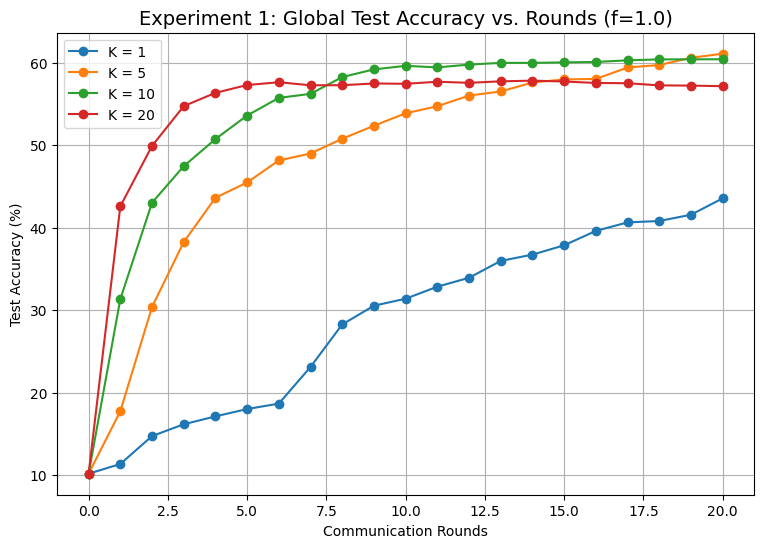

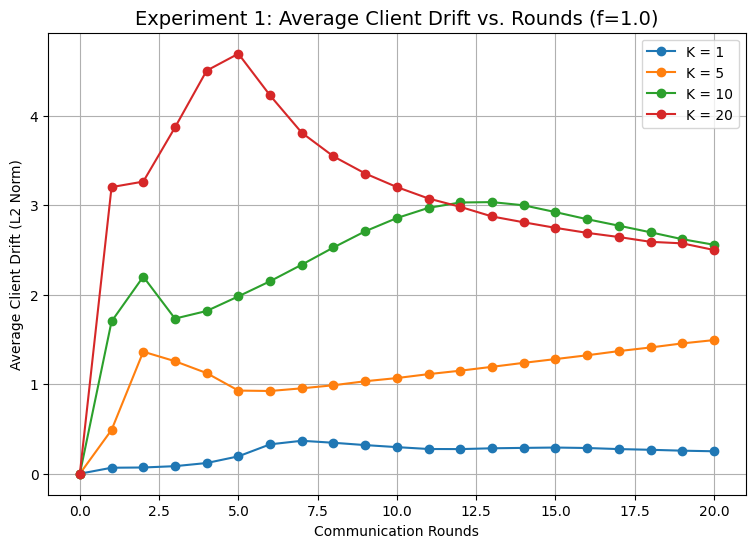

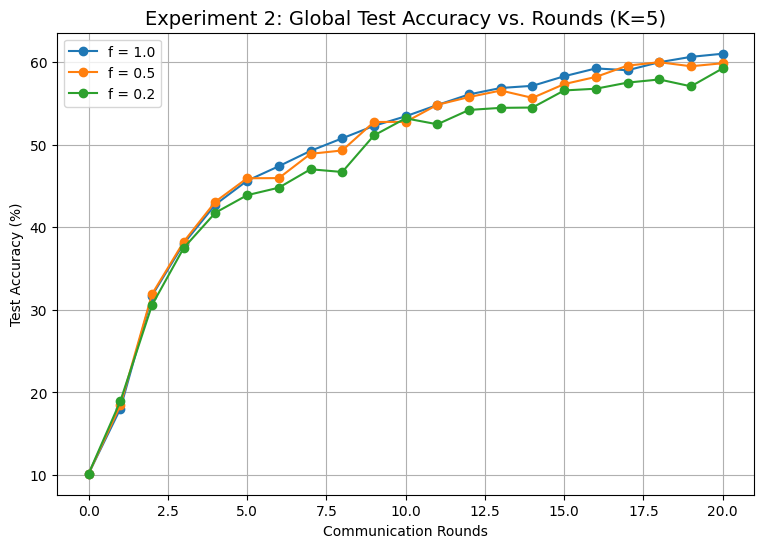

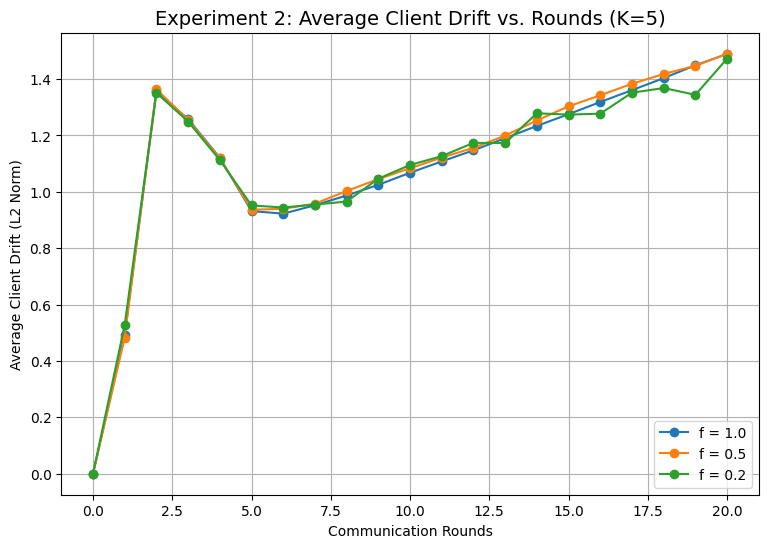


--- Summary Tables for Report ---

### Table 1: Summary of Experiment 1 (Varying K)
| K (Local Epochs) | Final Test Accuracy (%) | Peak Average Drift |
| :--- | :--- | :--- |
| 1 | 43.57% | 0.3683 |
| 5 | 61.12% | 1.4939 |
| 10 | 60.45% | 3.0364 |
| 20 | 57.18% | 4.6953 |

### Table 2: Summary of Experiment 2 (Varying f with K=5)
| `f` (Sampling Fraction) | Final Test Accuracy (%) | Peak Average Drift |
| :--- | :--- | :--- |
| 1.0 | 61.04% | 1.4888 |
| 0.5 | 59.89% | 1.4898 |
| 0.2 | 59.27% | 1.4722 |


In [20]:
###
# STEP 7: ANALYSIS & VISUALIZATION (FOR THE REPORT) 📈
###

# This cell generates four separate plots and two summary tables
# for easy inclusion in your report.

# Define the rounds (x-axis)
rounds = range(TOTAL_COMMUNICATION_ROUNDS + 1)

# --- Plot 1: Experiment 1 - Accuracy vs. K ---
plt.figure(figsize=(9, 6))
plt.title('Experiment 1: Global Test Accuracy vs. Rounds (f=1.0)', fontsize=14)
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy (%)')
for k, history in k_experiment_histories.items():
    plt.plot(rounds, history['test_accuracy'], 'o-', label=f'K = {k}')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Experiment 1 - Drift vs. K ---
plt.figure(figsize=(9, 6))
plt.title('Experiment 1: Average Client Drift vs. Rounds (f=1.0)', fontsize=14)
plt.xlabel('Communication Rounds')
plt.ylabel('Average Client Drift (L2 Norm)')
for k, history in k_experiment_histories.items():
    plt.plot(rounds, history['avg_client_drift'], 'o-', label=f'K = {k}')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 3: Experiment 2 - Accuracy vs. f ---
plt.figure(figsize=(9, 6))
plt.title(f'Experiment 2: Global Test Accuracy vs. Rounds (K={K_fixed})', fontsize=14)
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy (%)')
for f, history in f_experiment_histories.items():
    plt.plot(rounds, history['test_accuracy'], 'o-', label=f'f = {f}')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 4: Experiment 2 - Drift vs. f ---
plt.figure(figsize=(9, 6))
plt.title(f'Experiment 2: Average Client Drift vs. Rounds (K={K_fixed})', fontsize=14)
plt.xlabel('Communication Rounds')
plt.ylabel('Average Client Drift (L2 Norm)')
for f, history in f_experiment_histories.items():
    plt.plot(rounds, history['avg_client_drift'], 'o-', label=f'f = {f}')
plt.legend()
plt.grid(True)
plt.show()


# --- Summary Tables (for Report) ---

print("\n--- Summary Tables for Report ---")

# --- Table 1: Summary for K ---
print("\n### Table 1: Summary of Experiment 1 (Varying K)")
print("| K (Local Epochs) | Final Test Accuracy (%) | Peak Average Drift |")
print("| :--- | :--- | :--- |")
for k, history in k_experiment_histories.items():
    final_acc = history['test_accuracy'][-1]
    peak_drift = max(history['avg_client_drift'])
    print(f"| {k} | {final_acc:.2f}% | {peak_drift:.4f} |")

# --- Table 2: Summary for f ---
print("\n### Table 2: Summary of Experiment 2 (Varying f with K=5)")
print("| `f` (Sampling Fraction) | Final Test Accuracy (%) | Peak Average Drift |")
print("| :--- | :--- | :--- |")
for f, history in f_experiment_histories.items():
    final_acc = history['test_accuracy'][-1]
    peak_drift = max(history['avg_client_drift'])
    print(f"| {f} | {final_acc:.2f}% | {peak_drift:.4f} |")